# Relax inc. Take home challenge

In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
users = pd.read_csv('data/takehome_users.csv', encoding='iso-8859-1')
engagement = pd.read_csv('data/takehome_user_engagement.csv')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


## Data Cleaning

Steps:
- change NaN to 0 for 'invited_by_user_id'
- set object_id to user_id for possible merge later on
- add an 'adopted_user' column
    - defined as any user who has logged in on 3 seperate days in a 7 day period.
- convert 'creation_time' to datetime in users
- convert 'time_stamp' to datetime in engagement

In [7]:
# Convert datetime columns to datetime format
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
users['creation_time'] = pd.to_datetime(users['creation_time'])

# universal time conversion
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit = 's')

In [8]:
# replace missing phone entries with the most frequent type
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

In [9]:
# Equate user_id columns for dataframes 
users['user_id'] = users['object_id']
users = users.drop('object_id', axis=1)

### Create 'is_adopted' column

In [10]:
from datetime import datetime, timedelta

def check_for_user_activity_over_time_period(df, user_col, time_col, class_col, time_period = 7):
    
    '''
         
    The purpose of this function is to check the activity of a user over chunks of time in an entire 
    time period. The code is set up to check if a user was active for at least three seperate days
    in a 7 day period, over an entire time frame. It can be changed for less or more activity.
        
    ----------------------------------------------------------------------------------------------
    The use of this function us for classification purposes. The variables are defined below:
        
        df - the dataframe that holds the user_id column and the time_stamp column for each 
                 activity
        
        user_col - the user_id, as labaled in the df
        
        time_col - this should be a time stamp for each documented activity of the user
        
        class_col - this should be what the desired classification is, for example "is_retained"
        
        time_period - this is the time period that the function should check over, over the df
        
    '''
    
    # loop through each user
    user_ids = list(df[user_col].unique())
    
    # Set time_stamp as index for engagement
    df = df.set_index(time_col).sort_index()

    # This just squeezes out the day from each timestamp for grouping in the next line
    dates = pd.Series(df.index.get_level_values(time_col).date, name=time_col, index=df.index)

    # Group by the dates extracted above and by user_id
    df_temp = df.groupby([dates, user_col]).sum().sort_index()
    
    # Reset the index to re-create time_stamp column
    daily_visitors = df_temp.reset_index()
    
    # create dataframe to catch results
    adopted_users = pd.DataFrame(columns = [user_col, class_col])

    for user in user_ids:
        visits = daily_visitors[daily_visitors.user_id == user]  # filter for each user
        for i in range(len(visits)):       

            if i+3 <= len(visits): # if the user has logged in at least 3 days, check to see if it's within a week

                if i+3 == len(visits): # if the length is equal to 3 days, finalize loop here

                    if ((visits[time_col].values[i+2] - visits[time_col].values[i]) <= timedelta(days=time_period)):

                        adopted_users = adopted_users.append({user_col: user, class_col: 1}, ignore_index=True)
                        break

                    else:
                        adopted_users = adopted_users.append({user_col: user, class_col: 0}, ignore_index=True)
                        break

                elif i+3 < len(visits): # if the length is more than 3 days, loop through unless labaled adopted

                    if ((visits[time_col].values[i+2] - visits[time_col].values[i]) <= timedelta(days=time_period)):
                        adopted_users = adopted_users.append({user_col: user, class_col: 1}, ignore_index=True)
                        break

                    else:
                        continue

            elif i+3 > len(visits): # if the number of visits is less than three days, mark as not adopted

                adopted_users = adopted_users.append({user_col: user, class_col: 0}, ignore_index=True)
                break
    
    return adopted_users

In [11]:
adopted_users = check_for_user_activity_over_time_period(
                                                         engagement, 
                                                         'user_id', 
                                                         'time_stamp', 
                                                         'is_adopted', 
                                                         time_period = 7
                                                         )

In [12]:
adopted_users.head()

,user_id,is_adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


### Create user_length column

In [13]:
# User length is the time frame from the first login to the last
users['user_length'] = (users['last_session_creation_time'] - users['creation_time']).dt.total_seconds()

### Merge to create final dataframe for analysis

In [14]:
# final dataframe created by merging results from adopted_users
user_final = users.merge(adopted_users, on = 'user_id', how = 'left')

In [15]:
# some users have no engagements, they are all assigned as not adopted
user_final = user_final.fillna(0)

In [16]:
print("{}% of users adopted".format(100*(sum(user_final.is_adopted)/len(user_final.is_adopted))))

13.8% of users adopted


>The percent of actual adopted users is extremely low, if we model with accuracy here it could be misleading, predicting all not adopted would give an accuracy of 86%, for machine learning purposes later on we will keep this in mind. 

## Exploratory Data Analysis

In [17]:
def timeseries_frequency_plot(title, df, timeseries_col, y_col, dStart, dEnd, sample_by = 'D', xtick_freq = 'W'):
    
    '''This function will aggregate a dataframe by count given two columns, the datetime column and any column used to 
    determine frequency'''
    
    timeseries_vs_y = df[[timeseries_col, y_col]]
    plot_df = timeseries_vs_y.set_index(timeseries_col).resample(sample_by)[y_col].sum()
    df = plot_df[(dStart <= plot_df.index) & (plot_df.index <= dEnd)]

    ax = plt.figure(figsize=(20, 6)).add_subplot(111)   
    xticks = pd.date_range(start=dStart, end=dEnd, freq=xtick_freq)

    df.plot(ax = ax, xticks=xticks)
    
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels([x.strftime('%h%d\n%a\n%-I%p\n%Y') for x in xticks])
    
    ax.tick_params(axis='x', which='major', pad=15)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
    
    plt.show()

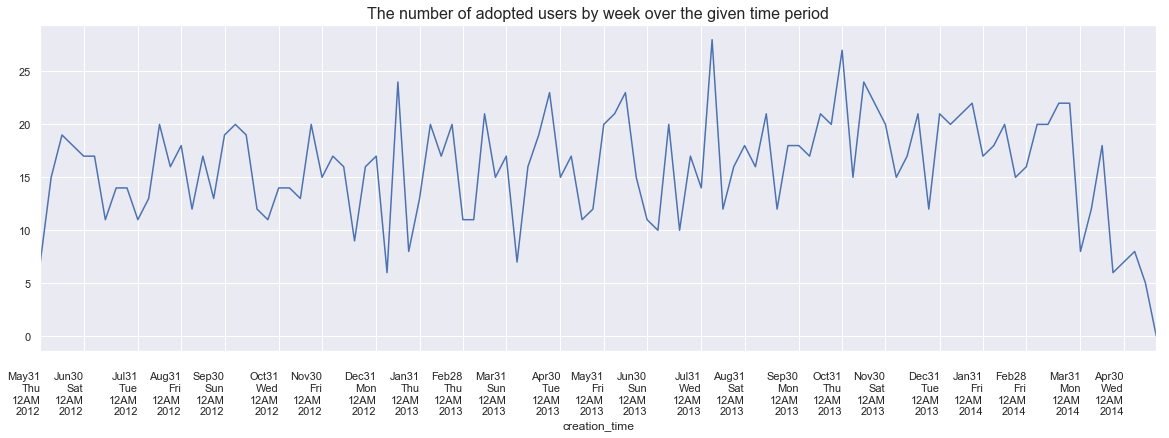

In [18]:
dStart = user_final['creation_time'].describe()[4]
dEnd = user_final['creation_time'].describe()[5]

timeseries_frequency_plot('The number of adopted users by week over the given time period', 
                          user_final, 
                          'creation_time', 
                          'is_adopted', 
                          dStart, 
                          dEnd, 
                          sample_by = 'W', 
                          xtick_freq = 'M'
                         )

> There appears to be a sharp drop off in weekly adopted users over the last two months, this may be some evidence of correlation between the length of a users account and the likelyhood that they become adopted. 

In [19]:
def get_pct_class_by_category(df, category, class_col):
    '''This function will output the percentage of classified values for the 
        categories in a given categorical variable'''
    
    retained = df.groupby([category, 'is_adopted']).agg({'is_adopted': 'count'})
    retained_pct = retained.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
    
    return retained_pct

In [20]:
def get_bar_labels(df, category, class_col):
    
    '''This function will output the percentage of classified values as a label for graphing'''
    
    pct_classified = get_pct_class_by_category(df, category, class_col)
    
    percentages = []
    for i in range(0, len(pct_classified[class_col])):
        if i % 2 != 0:
            percentages.append(pct_classified[class_col].iloc[i])
                
    bar_labels = []
    for i in range(len(percentages)):
        bar_labels.append("{}% retained".format(round(percentages[i], 1)))
    
    return bar_labels

In [21]:
def overlayed_labeled_bar_graph(df, category, class_col):
    '''This function will plot a bar graph with percent labels above each bar indicating the percentage of
        values in the labeled class'''
    
    bar_labels = get_bar_labels(df, category, class_col)
    
    y1 = df.groupby(category)[class_col].count()
    y2 = df.groupby(category)[class_col].sum()
    x = sorted(list(df[category].unique()))
    
    style = dict(size=15, color='grey')
    ax = plt.figure(figsize=(15, 6)).add_subplot(111)
    
    plt.bar(x, y1)
    plt.bar(x, y2)
    
    plt.title("{} adoption rates by category".format(category), size=16)
    
    # specific for this project
    plt.legend(['Not adopted', 'Adopted'])
    
    for i, title, label in zip(range(len(x)), x, bar_labels):
        ax.text(title, y1[i], label, ha="center", **style)

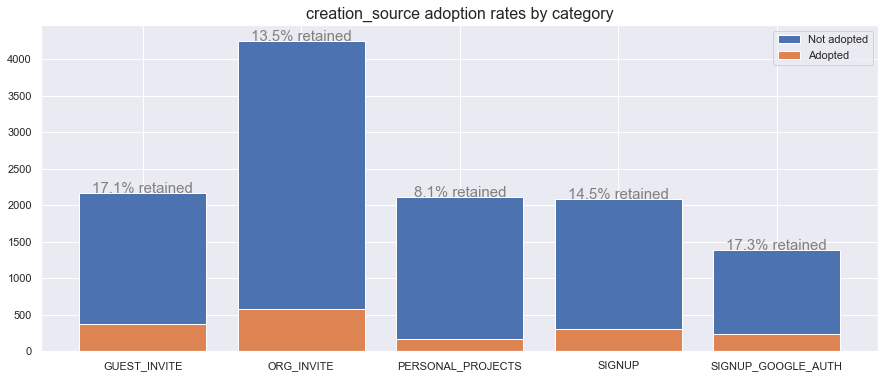

In [22]:
# How do adoption rates compare across creation sources?
overlayed_labeled_bar_graph(user_final, 'creation_source', 'is_adopted')

> It looks like guest invite and google signup havw the highest adoption rates, but there is little difference across categories.

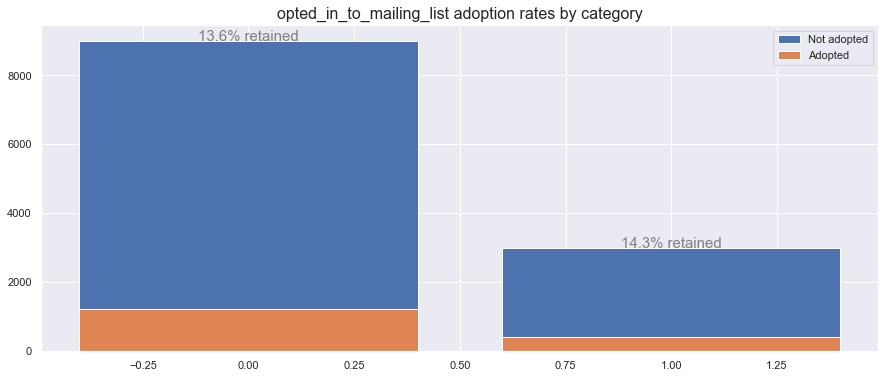

In [23]:
# How do adoption rates compare for those opted in to the mailing list?
overlayed_labeled_bar_graph(user_final, 'opted_in_to_mailing_list', 'is_adopted')

> There is virtually no difference in adoption between those who opted in to the mailing list and and those who did not. This may suggest an involuntary selection by the user. 

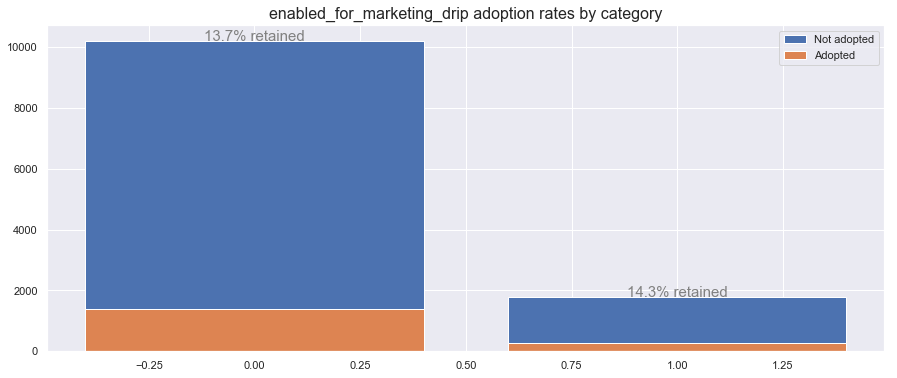

In [24]:
# How do adoption rates compare for those enabled for marketing drip?
overlayed_labeled_bar_graph(user_final, 'enabled_for_marketing_drip', 'is_adopted')

> Similar to opting in to the mailing list, those enabled for marketing drip are just as likely to be adopted as those who are not. 

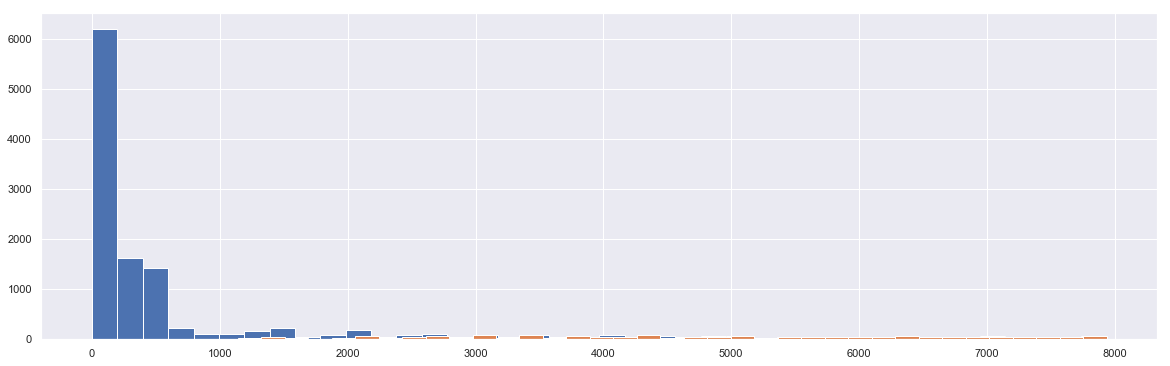

In [25]:
# How does the length of time a user is active affect the rate of adoption?
ax = plt.figure(figsize=(20, 6))
plt.hist(np.sqrt(user_final['user_length']), bins=40)
plt.hist(np.sqrt(user_final[user_final['is_adopted'] == 1]['user_length']), bins=40)
plt.show()

> Taking the square root reveals a bit more of the structure here but an ECDF would do a better job of displaying the percent distribution for user_length.

In [26]:
#define func to find ecdf of dataset
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

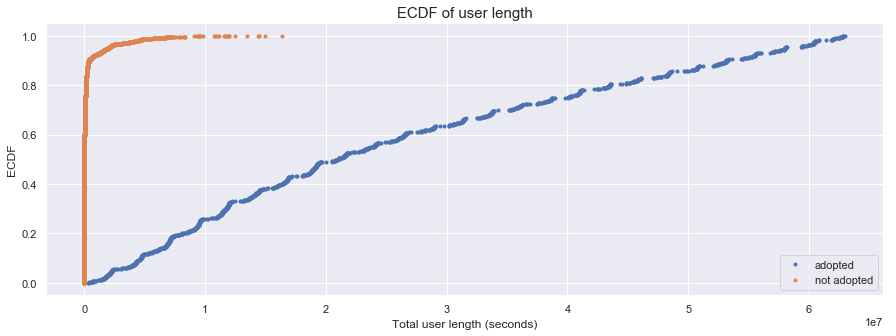

In [27]:
retained = user_final.user_length.loc[user_final['is_adopted'] == 1]
not_retained = user_final.user_length.loc[user_final['is_adopted'] == 0]

#set fig size
plt.figure(figsize=(15,5))

x_active, y_active = ecdf(retained)
x_inactive, y_inactive = ecdf(not_retained)

plt.plot(x_active, y_active, marker='.', linestyle='none')
plt.plot(x_inactive, y_inactive, marker='.', linestyle='none')
plt.title('ECDF of user length', size = 15)
plt.xlabel('Total user length (seconds)')
plt.ylabel('ECDF')
plt.legend(['adopted', 'not adopted'])
plt.show()

> It is clear from the plot that users who have a greater time between their first log in and their most recent are more likely to by adopted. 

## Feature Engineering

In [54]:
svm_df = user_final[['creation_source', 'invited_by_user_id', 'user_length', 'opted_in_to_mailing_list', 
                     'enabled_for_marketing_drip', 'is_adopted']]

In [55]:
# Dummy coding for col in dummy_cols
dummy_col = 'creation_source'

dummy = pd.get_dummies(svm_df[dummy_col])
svm_df = pd.concat([svm_df,dummy], axis=1)

# drop original columns before dummy-ing
svm_df = svm_df.drop(dummy_col, axis=1)

In [56]:
from sklearn.preprocessing import LabelEncoder

# For higher cardinality columns, employ label encoder 
enc_cols = 'invited_by_user_id'

data_list = svm_df[enc_cols].to_list()
values = np.array(data_list)
    
# initialize labelencoder, fit and transform
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
    
# Drop column and replace with encoded 
svm_df = svm_df.drop(enc_cols, axis = 1)
svm_df[enc_cols] = integer_encoded

In [57]:
svm_df['log_user_length'] = np.log1p(svm_df.user_length)

In [58]:
svm_df = svm_df.drop('user_length', axis=1)

In [59]:
from scipy.stats import skew
skew(svm_df['log_user_length'])

0.2230639788760071

In [60]:
svm_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,is_adopted,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,invited_by_user_id,log_user_length
0,1,0,0,1,0,0,0,0,2325,0.000000
1,0,0,1,0,1,0,0,0,56,16.279398
2,0,0,0,0,1,0,0,0,298,0.000000
3,0,0,0,1,0,0,0,0,1104,11.366755
4,0,0,0,1,0,0,0,0,1127,12.976183


## Machine Learning

In [61]:
from sklearn.model_selection import train_test_split
# Separate input features (X) and target variable (y)
y = svm_df.is_adopted
X = svm_df.drop('is_adopted', axis=1)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=3)

In [62]:
from sklearn.svm import SVC
# Train model
clf = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True,
            cache_size=7000)
 
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=7000, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Predict on training set
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

print("Accuracy score: ")
print(accuracy_score(y_test, y_pred))

print("F1 Score: ")
print(f1_score(y_test, y_pred))

[[3269  127]
 [  29  535]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      3396
           1       0.81      0.95      0.87       564

    accuracy                           0.96      3960
   macro avg       0.90      0.96      0.92      3960
weighted avg       0.97      0.96      0.96      3960

Accuracy score: 
0.9606060606060606
F1 Score: 
0.8727569331158237


In [64]:
from sklearn.metrics import roc_auc_score
# What about AUROC?
y_pred_prob = clf.predict_proba(X_test)[:,1]

print("AUROC Score: ")
print(roc_auc_score(y_test, y_pred_prob))

AUROC Score: 
0.9948748110000084


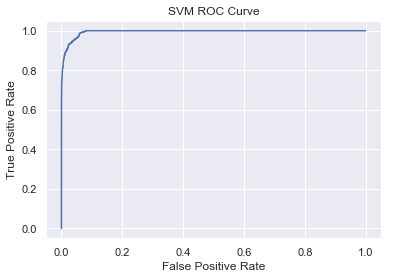

In [65]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve

# plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.show()

In [68]:
def plot_coefficients(classifier, feature_names, top_features=9):
    coef = classifier.coef_.ravel()
    top_coefficients = np.argsort(coef)
    # create plot
    plt.figure(figsize=(10, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title('Feature Importance', size = 15)
    plt.show()

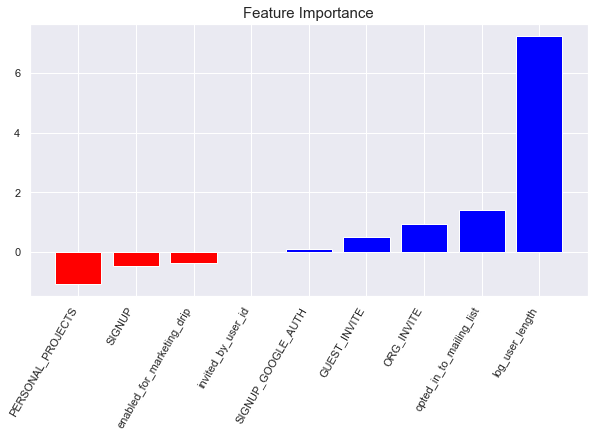

In [69]:
feature_names = list(svm_df.columns.drop('is_adopted'))
plot_coefficients(clf, feature_names)

## Results

Feature selection was made using an SVM model, as our dataframe was relatively small (<10^5) and sparse. The SVM model was also chosen for its ability to find the maximal margin between a nonlinear approximator. 

The results here suggest that the user length and and being opted in to the mailing list are among the most significant indicators of a user becoming adopted. Exploratory data analysis revealed a slight correlation between how a user was created and whether they became adopted, this was also reflected in the model results. Those invited by an organization or a guest were also strong indicators of adoption. 

I do have a few reservations about these results however. It is natural to assume that a longer time frame for a user would open greater opportunities for them to become adopted. For those who had signed up towards the end of the documented period, the likelihood that they became adopted reduced, as evidenced by a time series plot above. More work can be done here to limit the engagements to those who have been enrolled for at least a designated time period. 

The model results seemed promising. The accuracy for the SVM model was 96% and the AUROC was close to perfect. The data here was highly imbalanced however, so the more appropriate evaluation metric here is the F1 score, our model gave an F1 score of approximately an 87%.